# layout detection

In [1]:
from surya.detection import batch_text_detection
from surya.layout import batch_layout_detection
from surya.model.detection.segformer import load_model, load_processor
from surya.model.ordering.processor import load_processor as load_order_processor
from surya.model.ordering.model import load_model as load_order_model
from PIL import Image
from surya.settings import settings


def load_det_cached():
    checkpoint = settings.DETECTOR_MODEL_CHECKPOINT
    return load_model(checkpoint=checkpoint), load_processor(checkpoint=checkpoint)


# def load_rec_cached():
#     return load_rec_model(), load_rec_processor()


def load_layout_cached():
    return load_model(checkpoint=settings.LAYOUT_MODEL_CHECKPOINT), load_processor(checkpoint=settings.LAYOUT_MODEL_CHECKPOINT)

def load_order_cached():
    return load_order_model(), load_order_processor()


det_model, det_processor = load_det_cached()
# rec_model, rec_processor = load_rec_cached()
layout_model, layout_processor = load_layout_cached()
order_model, order_processor = load_order_cached()


/home/erwan/anaconda3/envs/scienceinfuse/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded detection model vikp/surya_det2 on device cuda with dtype torch.float16
Loaded detection model vikp/surya_layout2 on device cuda with dtype torch.float16
Loaded reading order model vikp/surya_order on device cuda with dtype torch.float16


In [2]:
from pathlib import Path
import os
from typing import List
import fitz
import io
import re
from PIL import Image, ImageFile
from unstructured.partition.pdf import partition_pdf
import shutil
import logging
from pymupdf import Document as PdfDocument
from typing import List, Tuple
from surya.postprocessing.heatmap import draw_polys_on_image
from surya.schema import OCRResult, TextDetectionResult, LayoutResult, OrderResult
from PIL import Image
from surya.ordering import batch_ordering
from surya.ordering import batch_ordering
from surya.detection import batch_text_detection
from surya.layout import batch_layout_detection
from surya.model.detection.segformer import load_model, load_processor
from surya.model.ordering.processor import load_processor as load_order_processor
from surya.model.ordering.model import load_model as load_order_model
from PIL import Image
from surya.settings import settings

def get_image_from_page(doc, page):
    page = doc[page]
    dpi = 72
    zoom = dpi / 72  # 72 is the default DPI
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return img


def texts_detection(images: List[Image.Image], batch_size=10) -> List[TextDetectionResult]:
    preds = batch_text_detection(images, det_model, det_processor, batch_size=batch_size)
    return preds

def layout_detection(images: List[Image.Image], batch_size=10) -> List[LayoutResult]:
    _det_preds = texts_detection(images, batch_size=batch_size)
    preds = batch_layout_detection(images, layout_model, layout_processor, _det_preds, batch_size=batch_size)
    return preds

def order_detection(images: List[Image.Image], batch_size=10) -> Tuple[List[Image.Image], List[OrderResult], List[List[str]]]:
    layout_preds = layout_detection(images, batch_size=batch_size)
    all_bboxes: List[List[List[float]]] = []
    all_labels: List[List[str]] = []
    for layout_pred in layout_preds:
        bboxes = [l.bbox for l in layout_pred.bboxes]
        labels = [l.label for l in layout_pred.bboxes]
        all_labels.append(labels)
        all_bboxes.append(bboxes)
    preds = batch_ordering(images, all_bboxes, order_model, order_processor, batch_size=batch_size)
    all_polys:List[List[List[List[float]]]] = []
    all_positions:List[List[str]] = []
    for pred in preds:
        polys = [l.polygon for l in pred.bboxes]
        all_polys.append(polys)
        positions = [str(l.position) for l in pred.bboxes]
        all_positions.append(positions)

    order_imgs: List[Image.Image] = []
    for idx, img in enumerate(images):
        order_img = draw_polys_on_image(all_polys[idx], img.copy(), labels=all_positions[idx], label_font_size=20)
        order_imgs.append(order_img)
    return order_imgs, preds, all_labels

def process_pdf_texts(doc, batch_size=2):
    images = [get_image_from_page(doc, pageNumber) for pageNumber in range(20)]
    # images = [get_image_from_page(doc, pageNumber) for pageNumber in range(len(doc))]
    # print(images)
    order_imgs, preds, labels = order_detection(images, batch_size=batch_size)
    return order_imgs, preds, labels


pdf_path = "./data/UniversScience/revue-decouverte/decouverte_436.pdf"
# pdf_path = "./data/UniversScience/dossiers-pédagogiques/astro/2015/2015 - Dinosaures.pdf"
doc = fitz.open(pdf_path)
result_imgs, result_preds, result_labels = process_pdf_texts(doc, batch_size=8)
# max 8 on my laptop, increse on server


Finding reading order: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


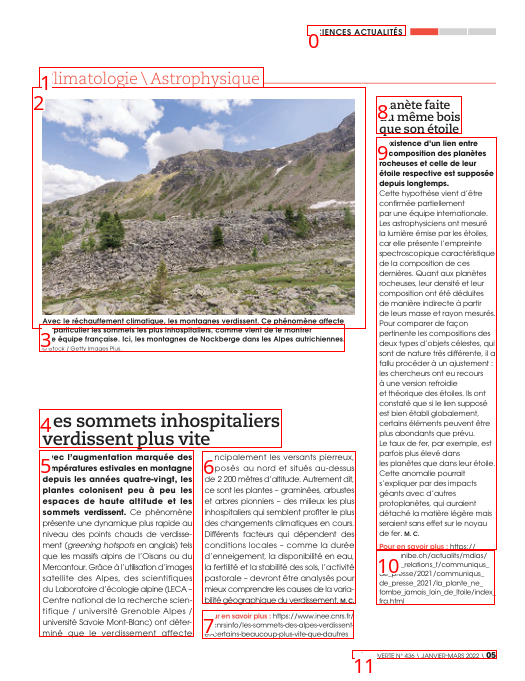

In [3]:
result_imgs[6]

In [ ]:
# import sys
# sys.path.append('..')

# from PIL import Image
# import pymupdf as fitz
# from pymupdf import Document
# def get_image_from_page(doc, page):
#     page = doc[page]
#     dpi = 72
#     zoom = dpi / 72  # 72 is the default DPI
#     mat = fitz.Matrix(zoom, zoom)
#     pix = page.get_pixmap(matrix=mat)
#     img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
#     return img

# pdf_path = "./data/UniversScience/dossiers-pédagogiques/astro/2015/2015 - Dinosaures.pdf"
# doc = fitz.open(pdf_path)

# images = [get_image_from_page(doc, pageNumber) for pageNumber in range(len(doc))]
# from app.processing.text.SISurya import SISurya
# surya = SISurya()
# result_imgs, result_preds, result_labels = surya.process_images(images)


In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import io
import pymupdf as fitz

labels = ["Caption","Footnote","Formula","List-item","Page-footer","Page-header","Picture","Figure","Section-header","Table","Text","Title"]
TITLES = ["Title"]
SUB_TITLES = ["Section-header", "Page-header"]
TEXTS = ["Text", "List-item"]

def restructure_text(text:str):
    """
    Restructures the given text by combining lines that start with '- ' into a single line, and removing leading/trailing whitespace from each line.
    It aims to deal with bullet lists in texts extracted from pdf 
    """
    lines = text.split('\n')
    result = []
    current_line = ''

    for line in lines:
        if line.startswith('- '):
            if current_line:
                result.append(current_line.strip())
            current_line = line
        else:
            current_line += ' ' + line.strip()

    if current_line:
        result.append(current_line.strip())

    return '\n'.join(result)

def keep_text(text:str):
    if (len(text) > 100):
        return True
    return False

# for page_index in range(len(doc)):
current_title = ""
current_subtitle = ""
for page_index in range(100)[0:20]:
    page = doc[page_index]
    preds = result_preds[page_index]
    labels = result_labels[page_index]
    img = result_imgs[page_index]

    display(img)
    # show = False
    # Sort bounding boxes by position
    sorted_indices = sorted(range(len(preds.bboxes)), key=lambda i: preds.bboxes[i].position)
    # Zip and iterate over sorted bounding boxes, labels, and indices
    for i in sorted_indices:
        box = preds.bboxes[i]
        label = labels[i]
        
        
        left, top, right, bottom = box.bbox
        # clean text
        text = restructure_text(page.get_text("text", clip=box.bbox))
        if (label in TITLES):
            current_title = text
        if (label in SUB_TITLES):
            current_subtitle = text

        width = img.width
        page_rect = page.rect
        page_width = page_rect.width
        page_height = page_rect.height
        if (keep_text(text) is True and label in TEXTS):
            show = True
            print("pos      :", box.position)
            print("label    :", label)
            print("cur_title:", current_title)
            print("cur_subtitle:", current_subtitle)
            print("text     :", text)
            print("len text :", len(text))
            print("\n===================\n")
    # if (show):
    #     display(img)
